https://archive.ics.uci.edu/ml/datasets/Taxi+Service+Trajectory+-+Prediction+Challenge%2C+ECML+PKDD+2015

http://www.geolink.pt/ecmlpkdd2015-challenge/dataset.html

- Objetivos:
    - EDA
    - Clustering
    
    
In this challenge, we propose you to build a predictive framework able to infer the final destination of each taxi ride based on their (initial) partial trajectories. This challenge is divisible in two different outputs: (a) the destination coordinates (WGS84) and (b) the total trip's travel time (counting from the service's starting point, in seconds).

References:

- https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea
- Remoção de outliers: http://colingorrie.github.io/outlier-detection.html
- https://stackoverflow.com/questions/28080066/how-to-reference-a-ipython-notebook-cell-in-markdown

# Indice

- [CALL_TYPE](#call_type)
- [ORIGIN_CALL](#origin_call)
- [ORIGIN_STAND](#origin_stand)
- [TIMESTAMP](#timestamp)
    - [Frequência de corridas por hora](#freq_corr_hora)
    - [Frequência de corridas para feriados](#freq_corr_feriados)
    - [Frequência de corridas para Feriados separados entre Normais e Religiosos](#freq_corr_fer_nor_rel)
    - [Frequência de corridas para os dias da semana (com média)](#freq_corr_dutil)
    - [Frequência de corridas entre dias úteis e finais de semana](#freq_corr_util_fds)
    - [Quantidade de corridas por mês e dia](#qtd_corr_mes_dia),
- [POLYLINE](#polyline)
    - [Distância total percorrida por corrida](#dist_perc)
        - [Identificação de outliers nos pontos](#dist_perc_outlier)
        


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import gc
import holidays
import ast

In [2]:
plt.figure(figsize=(15,5));
sns.set(rc={'figure.figsize':(15,5), 'xtick.direction':'in'});

<Figure size 1080x360 with 0 Axes>

In [3]:
def cfg_plot(title='', xlabel='', ylabel='', rotation=0):
    plt.xticks(rotation=rotation)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [4]:
# importando o train.csv

# dtypes={
#     'CALL_TYPE':'category',
#     'ORIGIN_CALL':'category',
#     'ORIGIN_STAND':'category',
#     'TAXI_ID':'category',
#     'DAY_TYPE':'category'
# }
# 
# usecols = ['CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'TIMESTAMP', 'DAY_TYPE', 'MISSING_DATA', 'POLYLINE']
# 
# df = pd.read_csv('train.csv', dtype=dtypes, usecols=usecols)
# 
# # dropping and converting some columns
# # TRIP_ID: id, DAY_TYPE: calculado errado no dataset.
# #df.drop(['TRIP_ID','DAY_TYPE' ], axis=1, inplace=True)
# df.TIMESTAMP = pd.to_datetime(df.TIMESTAMP, unit='s')

In [4]:
dtypes={
    'CALL_TYPE':'category',
    'ORIGIN_CALL':'category',
    'ORIGIN_STAND':'category',
    'TAXI_ID':'category',
    'DAY_TYPE':'category',
    'dist_perc':'float16'
}

# Remoção de colunas
# MISSING_DATA tem apenas 10 valores True. Removido da lista
# DAY_TYPE tem apenas o tipo A
usecols = ['CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 
           'TAXI_ID', 'TIMESTAMP', 
           'POLYLINE', 'dist_perc', 'start', 'stop']

df = pd.read_csv('train_tratado_outliers.csv', dtype=dtypes, usecols=usecols, parse_dates=True)

# cabeçalho minusculo
df.columns = df.columns.map(lambda x: x.lower())
#conversão da data de obj para datetime
df.timestamp = pd.to_datetime(df.timestamp)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710670 entries, 0 to 1710669
Data columns (total 9 columns):
call_type       category
origin_call     category
origin_stand    category
taxi_id         category
timestamp       datetime64[ns]
polyline        object
dist_perc       float16
start           object
stop            object
dtypes: category(4), datetime64[ns](1), float16(1), object(3)
memory usage: 71.5+ MB


In [6]:
df.head()

,call_type,origin_call,origin_stand,taxi_id,timestamp,polyline,dist_perc,start,stop
0,C,NaN,NaN,20000589,2013-07-01 00:00:58,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2.230469,"[-8.618643, 41.141412]","[-8.630838, 41.154489]"
1,B,NaN,7,20000596,2013-07-01 00:08:23,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",3.460938,"[-8.639847, 41.159826]","[-8.66574, 41.170671]"
2,C,NaN,NaN,20000320,2013-07-01 00:02:31,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",17.625000,"[-8.612964, 41.140359]","[-8.61597, 41.14053]"
3,C,NaN,NaN,20000520,2013-07-01 00:00:54,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",7.968750,"[-8.574678, 41.151951]","[-8.607996, 41.142915]"
4,C,NaN,NaN,20000337,2013-07-01 00:04:51,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",4.808594,"[-8.645994, 41.18049]","[-8.687268, 41.178087]"


<a id='call_type'></a>

**CALL_TYPE**



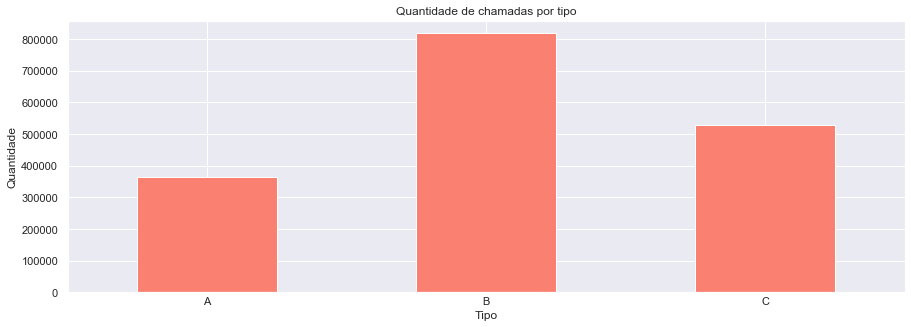

In [8]:
ax = df.call_type.value_counts().sort_index().plot(kind='bar', color='salmon')
cfg_plot('Quantidade de chamadas por tipo', 'Tipo', 'Quantidade')

- 'A' if this trip was dispatched from the central;
- 'B' if this trip was demanded directly to a taxi driver at a specific stand;
- 'C' otherwise (i.e. a trip demanded on a random street).

<a id='origin_call'></a>

**ORIGIN_CALL**

Essa coluna serve apenas quando ```call_type='A'```. Conta telefones que ligaram para a central pedindo uma corrida.

In [9]:
callers = df.origin_call.value_counts()[:15]
callers

2002     57571
63882     6406
2001      2499
13168     1314
6728      1115
5591      1051
14123      990
6654       909
2024       800
14045      769
3710       648
8939       559
12897      556
9682       534
4619       526
Name: origin_call, dtype: int64

Um único número fez 57571 chamadas. Será que é sempre o mesmo taxista que atende?

In [10]:
for index, value in zip(callers.index, callers.values):
    tax_qt = df[df.origin_call == index].taxi_id.value_counts().map(lambda x: x>0).sum()
    rt = value/tax_qt
    print('Caller:{0} --->  Qtd. calls:{1} ---> Diff. drivers:{2} ---> Calls/drivers ratio:{3:.2f}'.format(index, value,tax_qt, rt))

Caller:2002 --->  Qtd. calls:57571 ---> Diff. drivers:441 ---> Calls/drivers ratio:130.55
Caller:63882 --->  Qtd. calls:6406 ---> Diff. drivers:428 ---> Calls/drivers ratio:14.97
Caller:2001 --->  Qtd. calls:2499 ---> Diff. drivers:418 ---> Calls/drivers ratio:5.98
Caller:13168 --->  Qtd. calls:1314 ---> Diff. drivers:304 ---> Calls/drivers ratio:4.32
Caller:6728 --->  Qtd. calls:1115 ---> Diff. drivers:301 ---> Calls/drivers ratio:3.70
Caller:5591 --->  Qtd. calls:1051 ---> Diff. drivers:302 ---> Calls/drivers ratio:3.48
Caller:14123 --->  Qtd. calls:990 ---> Diff. drivers:249 ---> Calls/drivers ratio:3.98
Caller:6654 --->  Qtd. calls:909 ---> Diff. drivers:223 ---> Calls/drivers ratio:4.08
Caller:2024 --->  Qtd. calls:800 ---> Diff. drivers:329 ---> Calls/drivers ratio:2.43
Caller:14045 --->  Qtd. calls:769 ---> Diff. drivers:240 ---> Calls/drivers ratio:3.20
Caller:3710 --->  Qtd. calls:648 ---> Diff. drivers:239 ---> Calls/drivers ratio:2.71
Caller:8939 --->  Qtd. calls:559 ---> Di

Negativo! Vários taxistas são chamados para as corridas. Isso pode significar que o chamado é feito de acordo com a localização mais próxima entre usuário e taxista. Entretanto, o número que mais chamou não teve tantos taxistas diferentes quanto o segundo número que mais chamou. Isso se deve à quantidade de taxistas?

In [11]:
df.taxi_id.unique()

[20000589, 20000596, 20000320, 20000520, 20000337, ..., 20000248, 20000079, 20000940, 20000970, 20000931]
Length: 448
Categories (448, object): [20000589, 20000596, 20000320, 20000520, ..., 20000079, 20000940, 20000970, 20000931]

Isso mesmo. Dos 448 taxistas, quase todos já fizeram corrida para um mesmo número. Isso pode nos dizer que há aleatoriedade nos encaminhamentos ou que os taxistas estão bem espalhados por toda a cidade.

<a id='origin_stand'></a>

**ORIGIN_STAND**

In [12]:
df.origin_stand.unique()

[NaN, 7, 13, 28, 38, ..., 46, 41, 5, 4, 48]
Length: 64
Categories (63, object): [7, 13, 28, 38, ..., 41, 5, 4, 48]

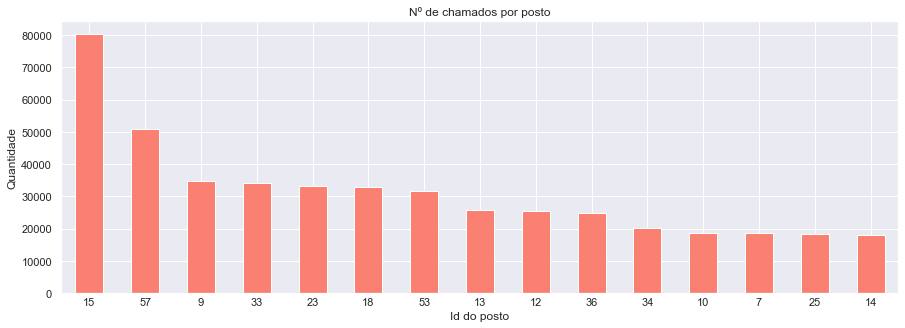

In [13]:
df.origin_stand.value_counts()[:15].plot(kind='bar', color='salmon')
cfg_plot('Nº de chamados por posto', 'Id do posto', 'Quantidade')

In [14]:
print('Média de chamados por posto: '+str(df.origin_stand.value_counts().mean()))
print('Desvio padrão de chamados por posto: '+str(df.origin_stand.value_counts().std()))

Média de chamados por posto: 12802.84126984127
Desvio padrão de chamados por posto: 13751.458844846069


Esses são os postos mais requisitados

<a id='timestamp'></a>

**TIMESTAMP**

In [8]:
df.timestamp.describe()

count                 1710670
unique                1655366
top       2014-03-27 19:31:22
freq                        5
first     2013-07-01 00:00:53
last      2014-06-30 23:59:56
Name: timestamp, dtype: object

O conjunto tem exatamente um ano de observações

In [6]:
dft = df.set_index('timestamp')

<a id='freq_corr_hora'></a>

**Frequência de corridas por hora**

In [7]:
dft['hour'] = dft.index.hour

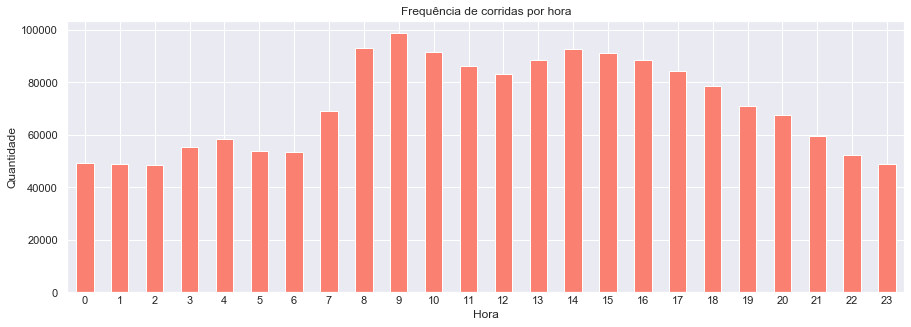

In [11]:
ax = dft['hour'].value_counts().sort_index(ascending=True).plot(kind='bar', color='salmon')
cfg_plot('Frequência de corridas por hora', 'Hora', 'Quantidade')

<a id='freq_corr_feriados'></a>

**Frequencia de corridas para feriados**

In [12]:
tipo_hol = {'2013-01-01':'Normal','2013-03-29':'Religioso','2013-03-31':'Religioso','2013-04-25':'Normal',
            '2013-05-01':'Normal','2013-06-10':'Normal','2013-08-15':'Religioso','2013-12-08':'Religioso',
            '2013-12-25':'Religioso','2014-01-01':'Normal','2014-04-18':'Religioso','2014-04-20':'Religioso',
            '2014-04-25':'Normal','2014-05-01':'Normal','2014-06-10':'Normal','2014-08-15':'Religioso',
            '2014-12-08':'Religioso','2014-12-25':'Religioso'}

hlds = [(str(date), desc, tipo_hol[str(date)]) for date, desc in sorted(holidays.Portugal(years=[2013, 2014]).items())]

In [13]:
hlds[0]

('2013-01-01', 'Ano Novo', 'Normal')

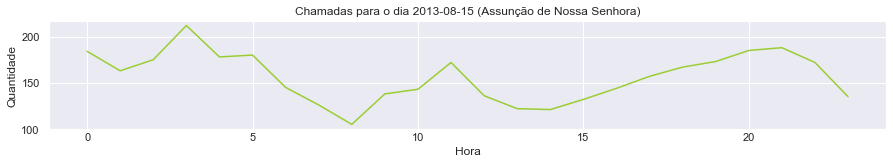

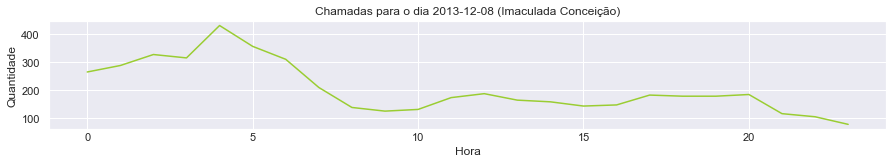

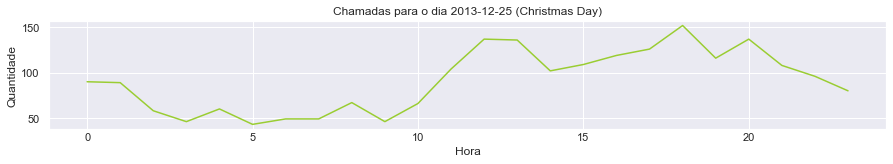

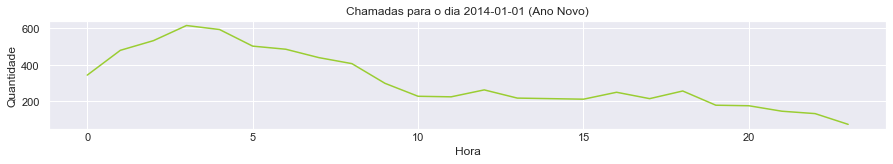

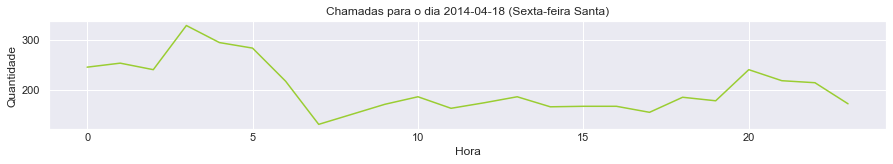

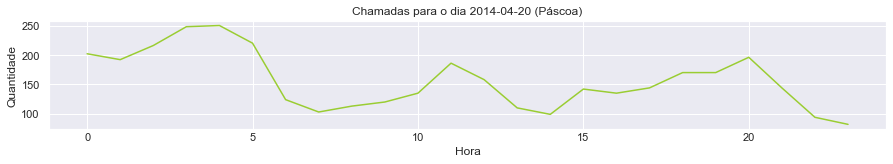

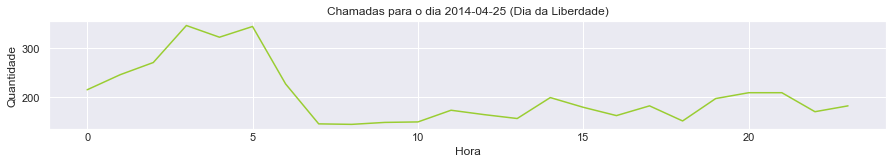

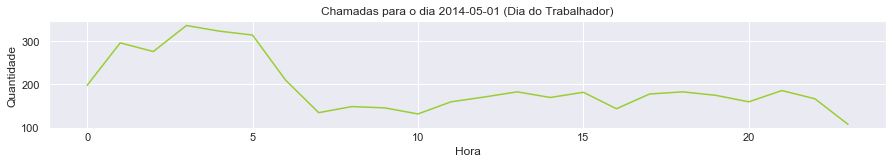

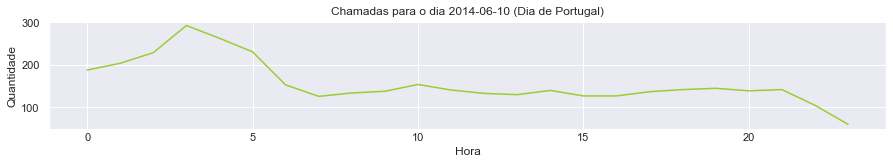

In [14]:
for date, desc, _ in hlds:
    if len(dft[date].index) > 0:
        plt.figure(figsize=(15,2))
        dft[date].index.hour.value_counts().sort_index(ascending=True).plot(kind='line', color='yellowgreen')
        title_ = 'Chamadas para o dia {0} ({1})'.format(date, desc)
        cfg_plot(title_, 'Hora', 'Quantidade')
        
        

- Os feriados tem um comportamento interessante. Com exceção do Natal, todos eles tem um pico de chamadas entre 00:00 e 05:00 e praticamente se mantém estáveis durante o resto do dia.
- O natal, contraria todos os outros feriados. Existem 2 picos de chamados: um entre 11:00 e 14:00 e às 19:00. A comilança nesse dia não é apenas no Brasil, mas em Portugal também. :D
- A páscoa também segue a frequêcia do Natal. mas com 3 picos. Além do almoço e ceia, também há um na madrugada. 
- Um fato interessante do ano novo, é a quantidade de chamados entre 00:00 e 05:00. É a maior ocorrência entre todos feriados.


<a id='freq_corr_fer_nor_rel'></a>

**Frequencia de corridas para Feriados separados entre Normais e Religiosos**

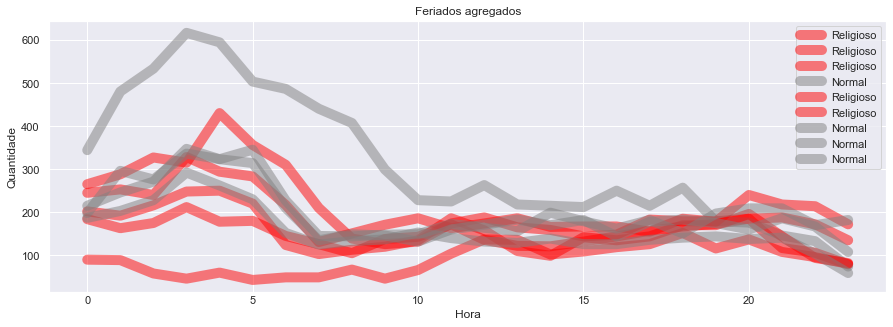

In [15]:
for date, desc, tipo in hlds:
    if len(dft[date].index) > 0:
        item_ = dft[date].index.hour.value_counts().sort_index(ascending=True)
        plt.plot(item_.index, item_.values, label=tipo, color= 'gray' if tipo=='Normal' else 'red', alpha=0.5, linewidth=10)
        #title_ = 'Chamadas para o dia {0} ({1})'.format(date, desc)
        plt.legend()
cfg_plot('Feriados agregados', 'Hora', 'Quantidade')


Analisando todos feriados juntos e separando-os entre normais e religiosos, é possível ver que existem 2 discrepâncias interessantes:
- A linha discrepante cinza corresponde ao ano novo. As chamadas ficam acima da média dos outros feriados.
- Contrariamente a linha discrepante vermelha corresponde ao Natal. Nesse dia as chamadas estão bem abaixo da média.
- Os outros feriados seguem uma linha média.

<a id='freq_corr_dutil'></a>

**Frequencia de corridas para os dias da semana (com média)**

In [16]:
# Monday= 0 - seg
# tuesday= 1
# wednesday= 2
# thursday= 3
# friday= 4
# saturday= 5
# Sunday= 6 - dom

In [17]:
wkday = dft.index.dayofweek.value_counts().sort_index()
wkday.index = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom']

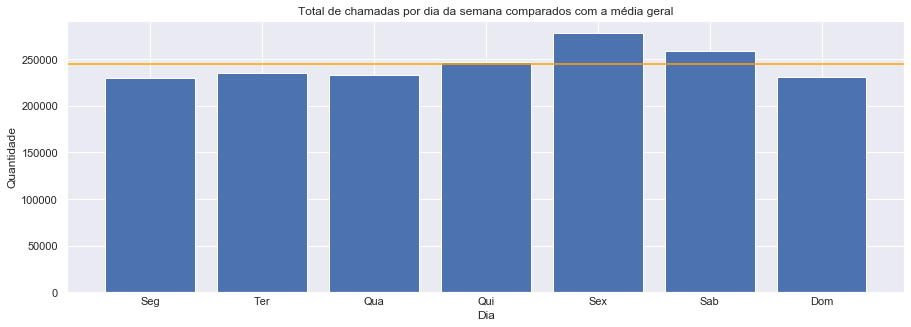

In [18]:
plt.bar(wkday.index, wkday.values)
plt.axhline(dft.index.dayofweek.value_counts().mean(), color='orange')
cfg_plot('Total de chamadas por dia da semana comparados com a média geral', 'Dia', 'Quantidade')

<a id='freq_corr_util_fds'></a>

**Frequencia de corridas entre dias úteis e finais de semana**

In [8]:
def fds(x):
    if x.dayofweek ==5 or x.dayofweek ==6:
        return 1
    else:
        return 0

In [9]:
dft['fds'] = dft.index.map(fds)

In [21]:
dft.fds.value_counts()

0    1221637
1     489033
Name: fds, dtype: int64

In [22]:
hr_fds = dft[['hour', 'fds']]

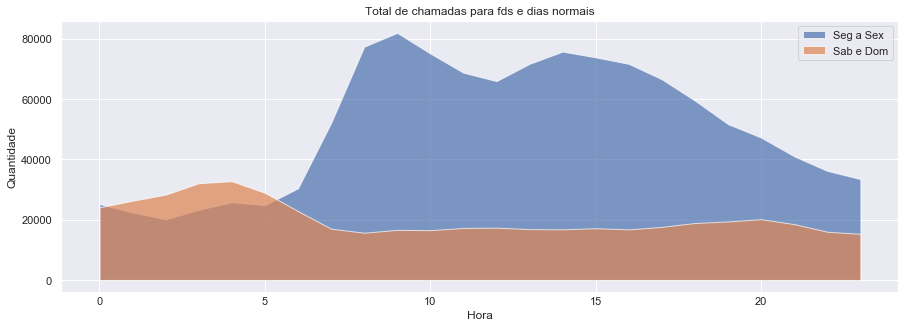

In [23]:
for ss, label in [(0, 'Seg a Sex'),(1, 'Sab e Dom')]:
    fds_ = hr_fds[hr_fds.fds == ss].hour.value_counts().sort_index()
    plt.fill_between(fds_.index, fds_.values, label=label, alpha=0.7)
    plt.legend()

cfg_plot('Total de chamadas para fds e dias normais', 'Hora', 'Quantidade')

- A curva de final de semana é bem parecida com a curva de feriados (auge entre 0 e 5 da manhã e depois diminui/estabiliza.
- Durante a semana o pico está mais ou menos entre 8 e 9. Horário que as pessoas vão apra o trabalho. Outro pico está localizado um pouco depois da hora do almoço.

<a id='qtd_corr_mes_dia'></a>

**Quantidade de corridas por mês e dia**

Será que existe uma relação entre começo do mes e final do mês pras chamadas?

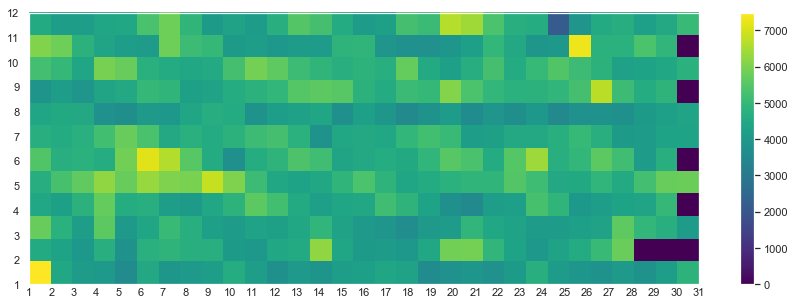

In [24]:
plt.hist2d(dft.index.day, dft.index.month, bins=[31,12], cmap='viridis')
plt.xticks(range(1,32))
plt.yticks(range(1,13))
plt.grid(False)
plt.colorbar()

plt.show()

Não existe essa relação em geral. Alguns meses tem um aumento súbito mas nada que aponte um padrão. Feriados como natal e ano novo são bem notáveis.

Dia de trabalho - mean

<a id='polyline'></a>

**POLYLINE**

- Todos destinos (pra onde as pessoas mais vão?)
    - em dias de semana, dias de trabalho, feriado?

In [7]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    
    https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    #dlon = lon2 - lon1 
    #dlat = lat2 - lat1 
    a = sin((lat2 - lat1)/2)**2 + cos(lat1) * cos(lat2) * sin((lon2 - lon1)/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [ ]:
def outliers_iqr(line):
    """
    Indentify outliers based in IQR.
    Used for remove outliers in gps points.
    """
    if line.size>0:
        q1_lon, q3_lon = np.percentile(line[:,0], [25, 75])
        iqr_lon = q3_lon - q1_lon
        lower_bound_lon = q1_lon - (iqr_lon * 1.5)
        upper_bound_lon = q3_lon + (iqr_lon * 1.5)
        

        q1_lat, q3_lat = np.percentile(line[:,1], [25, 75])
        iqr_lat = q3_lat - q1_lat
        lower_bound_lat = q1_lat - (iqr_lat * 1.5)
        upper_bound_lat = q3_lat + (iqr_lat * 1.5)
        
        # print(np.where((line[:,0] > upper_bound_lon) | (line[:,0] < lower_bound_lon))[0], '----', np.where((line[:,1] > upper_bound_lat) | (line[:,1] < lower_bound_lat))[0], '-----', final)
       
        return np.unique(np.concatenate([np.where((line[:,0] > upper_bound_lon) | (line[:,0] < lower_bound_lon))[0], \
                                         np.where((line[:,1] > upper_bound_lat) | (line[:,1] < lower_bound_lat))[0]], axis=0))

In [1]:
# Quarta versão dessa função
# Ultima alteração: remover outliers.

def converte_dots_b(x):
    """
    Faz a contagem da distancia para todos os pontos registrados na
    coluna POLYLINE.

    50 minutos para 1,7 mi de regs
    """
    global cont;
    
    try:
        cont+=1
        dist=0
        line = np.array(ast.literal_eval(x))
       
        #print(list(set(outliers)))
        if len(line) > 0:
            line=np.delete(line,list(outliers_iqr(line)), 0)
            
        for index,_ in enumerate(line):
            lon1, lat1, lon2, lat2 = line[index:index+2,].ravel()
            #print(lon1, lat1, lon2, lat2)
            #print(line[index:index+2,].ravel())
            dist += haversine(lon1, lat1, lon2, lat2)
    except Exception as e:
        #print(cont, e)
        None
    finally:
        if cont%10000 ==0: print(datetime.datetime.now(), cont)
        return round(dist,2)

<a id='dist_perc'></a>

**Distância total percorrida por corrida**

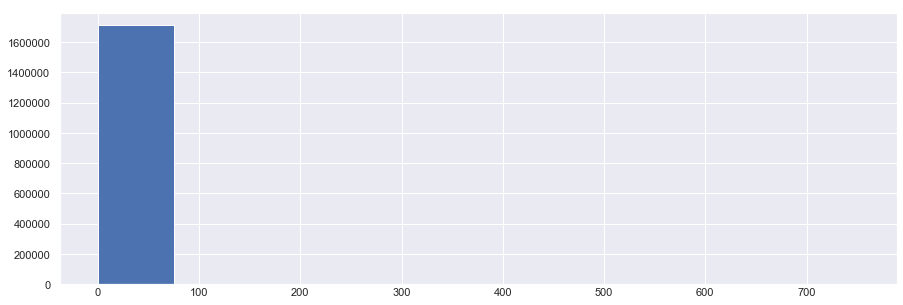

In [13]:
plt.hist(dft.dist_perc)
plt.show()

Opa, parece que existe um outlier. Reduzindo o range:

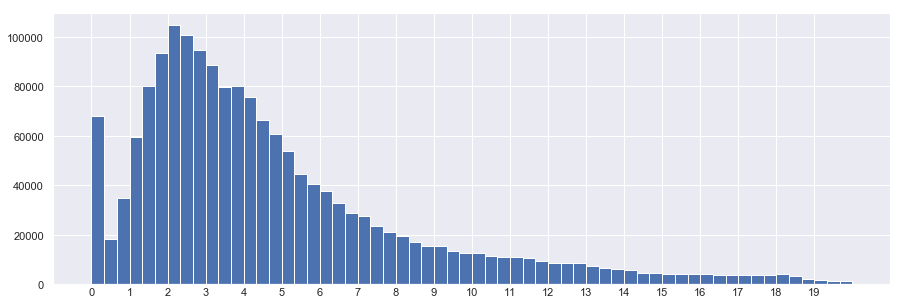

In [14]:
plt.hist(dft.dist_perc, bins=60, range=(0, 20))
plt.xticks(range(0,20))
plt.show()

In [15]:
print('Quantidade de corridas de até 20 km: {0}%'.format(len(dft[dft.dist_perc < 20].dist_perc)/len(dft.dist_perc) * 100))
print('Quantidade de corridas de até 20 km (descontando corridas sem distância: {0}%'.format(len(dft[(dft.dist_perc < 20) & (dft.dist_perc > 0)].dist_perc)/len(dft.dist_perc) * 100))

Quantidade de corridas de até 20 km: 98.5036272337739%
Quantidade de corridas de até 20 km (descontando corridas sem distância: 96.13397090029054%


A maioria das corridas são entre 2 e 3 km. Existem também muitos valores com quilometragem zerada (~2% do total).

Quais são as maiores distâncias percorridas?

In [16]:
dft.dist_perc.sort_values(ascending=False)[:10]

timestamp
2013-12-10 11:12:26    751.5
2014-01-30 12:41:46    671.0
2014-02-03 15:43:57    642.0
2013-07-01 08:01:22    635.5
2013-11-06 08:22:45    635.5
2014-03-26 06:05:20    633.5
2013-11-12 11:26:35    624.5
2013-11-04 13:58:15    596.0
2014-05-31 07:04:28    591.5
2014-03-26 12:40:45    582.5
Name: dist_perc, dtype: float16

<a id='dist_perc_outlier'></a>

Interessante. Será que os táxis realmente andam tudo isso? Vamos investigar ver o que mais andou:

In [58]:
np.array(ast.literal_eval(dft['2014-04-02 13:17:56'].polyline[0]))

array([[ -8.630694,  41.154858],
       [ -8.630703,  41.15493 ],
       [ -8.63073 ,  41.154912],
       [ -8.63073 ,  41.154876],
       [ -8.630739,  41.154885],
       [ -8.63073 ,  41.154651],
       [ -8.630613,  41.153688],
       [ -8.630613,  41.153049],
       [ -8.630649,  41.152716],
       [ -8.630694,  41.152671],
       [ -8.630685,  41.152662],
       [ -8.630676,  41.152653],
       [ -8.630667,  41.152644],
       [ -8.630721,  41.15259 ],
       [ -8.631891,  41.152644],
       [ -8.632296,  41.152689],
       [ -8.632386,  41.152698],
       [ -8.634447,  41.152482],
       [ -8.636067,  41.152545],
       [ -8.636994,  41.152761],
       [ -8.637885,  41.152977],
       [ -8.638515,  41.153643],
       [ -8.637912,  41.15484 ],
       [ -8.637021,  41.15664 ],
       [ -8.636436,  41.157819],
       [ -8.636049,  41.158611],
       [ -8.636004,  41.158692],
       [ -8.635995,  41.158701],
       [ -8.635869,  41.15898 ],
       [ -8.637075,  41.159322],
       [ -

**OUTLIER!** Na penúltima posição existe um outlier que aumenta drásticamente (esse ponto está no meio do oceano) a corrida desse táxi. Esses outliers tem que ser removidos antes de qualquer análise!

Plotando um boxplot para tirar a dúvida:

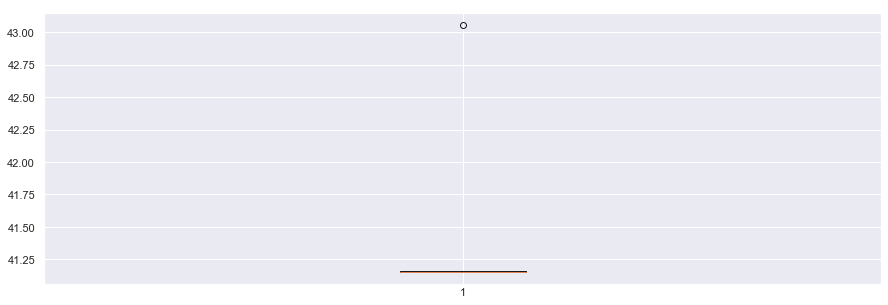

In [84]:
plt.boxplot(np.array(ast.literal_eval(dft['2014-04-02 13:17:56'].polyline[0]))[:,1])
plt.show()

Realmente, é bem notável o outlier. É bem possível que aplicando a técnica acima, os outliers sejam tratados corretamente!

**Como remover os outliers?**
- Score Z (não vamos usar esse pois ele é sensível a poucos itens)
- IQR (vamos usar esse ---> outliers_iqr())

Como a ``dist_perc`` é calculada por uma função, então já adicionei a verificação na função ``converte_dots_b()``. 

In [25]:
# +- 30 minutos para cada operação

# %%time
# cont=0
# df['dist_perc'] = df.POLYLINE.apply(converte_dots_b)
# df['start'] = df.POLYLINE.apply(lambda x: ast.literal_eval(x)[0] if len(x)>2 else None)
# df['stop'] = df.POLYLINE.apply(lambda x: ast.literal_eval(x)[-1] if len(x)>2 else None)
# 
# df.to_csv('train_tratado.csv', index=False, chunksize=700)

Removido os outliers, vamos verificar novamente se os pontos no mapa estão com problema ainda:

In [24]:
dft.sort_values(by='dist_perc', ascending=False)[:10]

,call_type,origin_call,origin_stand,taxi_id,polyline,dist_perc,start,stop,hour,fds
timestamp,,,,,,,,,,
2013-12-10 11:12:26,C,NaN,NaN,20000506,"[[-8.557533,40.846599],[-8.555796,40.842054],[...",751.5,"[-8.557533, 40.846599]","[-8.637651, 41.096223]",11,0
2014-01-30 12:41:46,C,NaN,NaN,20000902,"[[-8.680986,41.157567],[-8.680167,41.156604],[...",671.0,"[-8.680986, 41.157567]","[-8.642286, 41.070501]",12,0
2014-02-03 15:43:57,C,NaN,NaN,20000902,"[[-8.672364,41.154831],[-8.670393,41.155974],[...",642.0,"[-8.672364, 41.154831]","[-8.682021, 41.158863]",15,0
2013-11-06 08:22:45,C,NaN,NaN,20000276,"[[-8.646318,41.157072],[-8.644878,41.153787],[...",635.5,"[-8.646318, 41.157072]","[-8.663112, 41.163435]",8,0
2013-07-01 08:01:22,C,NaN,NaN,20000084,"[[-8.630793,41.154606],[-8.630829,41.154309],[...",635.5,"[-8.630793, 41.154606]","[-9.136584, 38.71548]",8,0
2014-03-26 06:05:20,C,NaN,NaN,20000243,"[[-8.578179,41.158683],[-8.577594,41.158629],[...",633.5,"[-8.578179, 41.158683]","[-8.577882, 41.158629]",6,0
2013-11-12 11:26:35,C,NaN,NaN,20000163,"[[-8.662446,41.147703],[-8.662482,41.147721],[...",624.5,"[-8.662446, 41.147703]","[-8.571393, 41.049531]",11,0
2013-11-04 13:58:15,B,NaN,15,20000370,"[[-8.585667,41.148558],[-8.585712,41.148801],[...",596.0,"[-8.585667, 41.148558]","[-8.527032, 41.181192]",13,0
2014-05-31 07:04:28,C,NaN,NaN,20000681,"[[-7.49133,37.184832],[-7.491906,37.187829],[-...",591.5,"[-7.49133, 37.184832]","[-8.591058, 41.155065]",7,1


Plotar mapa aqui das 10 maiores corridas!

In [63]:
dst_mean_std = dft.groupby(dft.index.dayofweek).agg(['mean', 'median'])['dist_perc']
dst_mean_std.index = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom']

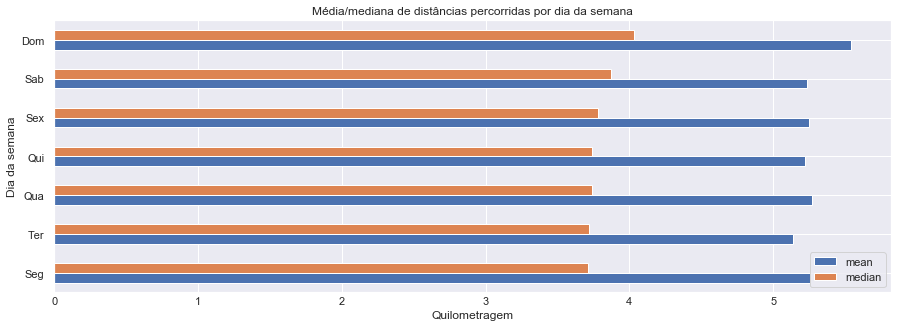

In [68]:
dst_mean_std.plot(kind='barh')
cfg_plot('Média/mediana de distâncias percorridas por dia da semana', 'Quilometragem', 'Dia da semana', rotation=0)

A quantidade percorrida no domingo é um pouco maior do que nos outros dias. Será que isso se deve ao turismo?

**Média de distância percorrida por hora**

In [128]:
dst_['calls'] = dft.hour.value_counts()/10000

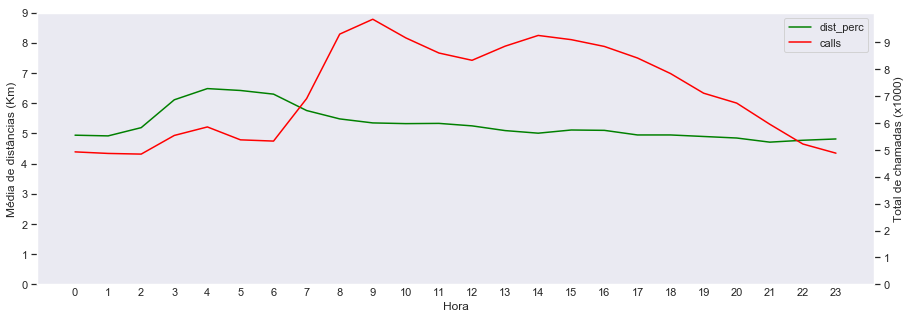

In [144]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(dst_.index, dst_.dist_perc, color='green')
ax2.plot(dst_.index, dst_.calls, color='red')

ax1.set_xlabel('Hora')
ax1.set_ylabel('Média de distâncias (Km)')
ax1.grid(False)
ax1.set_xticks(range(0,24))
ax1.set_yticks(np.arange(0,10))

ax2.set_ylabel('Total de chamadas (x1000)')
ax2.grid(False)
ax2.set_yticks(range(0,10))

handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles,labels)
plt.show()
# https://stackoverflow.com/questions/14762181/adding-a-y-axis-label-to-secondary-y-axis-in-matplotlib
# https://stackoverflow.com/questions/33611803/pyplot-single-legend-when-plotting-on-secondary-y-axis

Esse gráfico é muito interessante. No horário de expediente as distâncias percorridas são menores que de madrugada, entretanto, a quantidade de chamadas é maior. Esse comportamento é inverso na madrugada: menos chamadas, porém maiores distâncias percorridas.

**10 taxistas que mais andaram no ano**

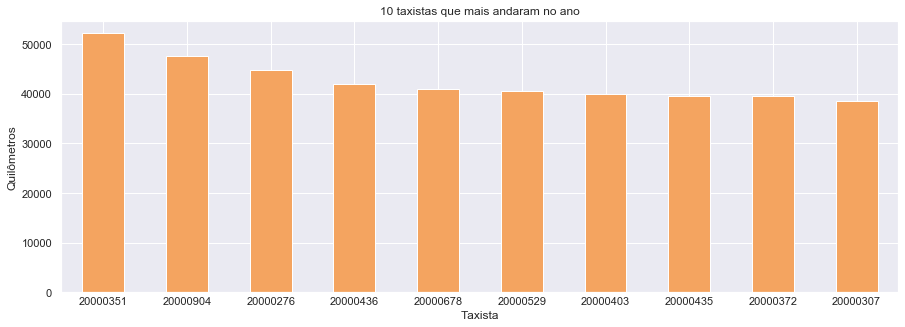

In [162]:
df.groupby('taxi_id').sum()['dist_perc'].sort_values(ascending=False)[:10].plot(kind='bar', color='sandybrown')
cfg_plot('10 taxistas que mais andaram no ano', 'Taxista', 'Quilômetros')

52 mil km! Em média anual, é como se esse taxista andasse 142 km por dia, quase 6 km por hora. A média de corridas fica entre 5 e 6 km, então, é como se o taxista fizesse uma corrida por hora. Claro que nessa conta estão sendo levados os dias que o taxista não trabalha por exemplo.

**Média de quilomêtros por taxista**

In [160]:
# float16 tem baixa precisao, tende ao infinito
# transformar a serie para np.array antes de fazer o procedimento acima
df.groupby('taxi_id').sum()['dist_perc'].values.mean(dtype=float)

20128.700985159194

**Como é a vida do taxista de mais anda no ano?**

In [214]:
dft['dayweek'] = dft.index.dayofweek

In [242]:
dft2 = dft[dft.taxi_id=='20000351']
dft2['month'] = dft2.index.month
dft2['day'] = dft2.index.day

C:\Users\a46396\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\a46396\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


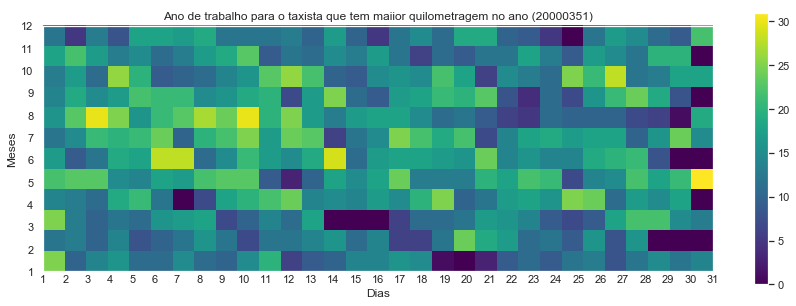

In [288]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
hist, xbins, ybins, im = plt.hist2d(dft2.day, dft2.month, bins=[31,12], cmap='viridis')
plt.xticks(range(1,32))
plt.yticks(range(1,13))
plt.grid(False)
plt.colorbar()


cfg_plot('Ano de trabalho para o taxista que tem maiior quilometragem no ano (20000351)', 'Dias', 'Meses')

Em geral parece que esse taxista não descansa nos finais de semana. Poucos dias do ano ele não trabalhou.